In [1]:
!qbraid jobs enable amazon_braket
#corey's stuff

 
# Recursive Function to find the
# Maximal Independent Vertex Set   
def graphSets(graph):
     
    # Base Case - Given Graph
    # has no nodes
    if(len(graph) == 0):
        return []
    
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
     
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
     
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
     
    # Delete current vertex
    # from the Graph
    del graph2[vCurrent]
     
    # Recursive call - Gets
    # Maximal Set,
    # assuming current Vertex
    # not selected
    res1 = graphSets(graph2)
     
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
 
    # Loop through its neighbours
    for v in graph[vCurrent]:
         
        # Delete neighbor from
        # the current subgraph
        if(v in graph2):
            del graph2[v]
     
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
     
    # Our final result is the one
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2
 
# Driver Code
V = 8
 
E = [ (1, 2),
      (1, 3),
      (2, 4),
      (5, 6),
      (6, 7),
      (4, 8)]
 
graph = dict([])
 
# Constructs Graph as a dictionary
# of the following format-
 
# graph[VertexNumber V]
# = list[Neighbors of Vertex V]
for i in range(len(E)):
    v1, v2 = E[i]
     
    if(v1 not in graph):
        graph[v1] = []
    if(v2 not in graph):
        graph[v2] = []
     
    graph[v1].append(v2)
    graph[v2].append(v1)
 
# Recursive call considering
# all vertices in the maximum
# independent set
maximalIndependentSet = graphSets(graph)
 
# Prints the Result
for i in maximalIndependentSet:
    print(i, end =" ")



You have already enabled qBraid Quantum Jobs in the amazon_braket environment.
2 3 5 7 8 

In [2]:
!qbraid jobs enable amazon_braket
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx
from scipy.optimize import minimize

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [3]:
from braket.aws import AwsDevice
from braket.devices import LocalSimulator

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

# get C6 coefficient in rad m^6/sec Pull from capabilities attribute
C6 = float(capabilities.rydberg.dict()['c6Coefficient'])

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
test:  []


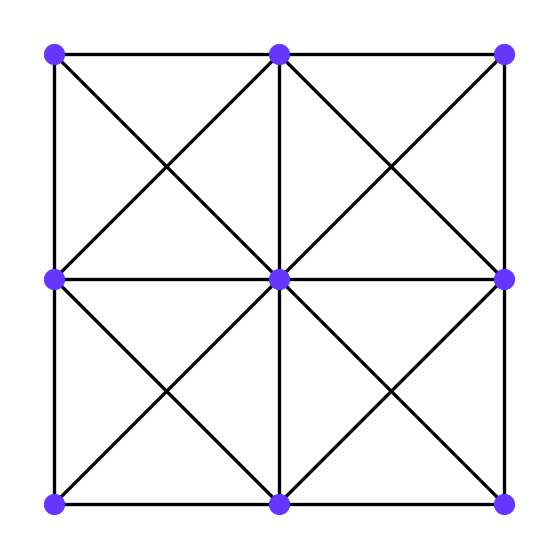

In [4]:
from iquhack_utils import visualize_graph

def kings_graph(numx,numy,filling=0.7,seed=None):
    '''
    Generate a next nearest neighbor graph with a lattice constant 1, with some number of nodes removed
    numx    - number of grid points in the X direction
    numy    - number of grid points in the Y direction
    filling - Fraction of vertices to be kept. Total number of vertices is int(numx*numy*filling)
    
    Returns
    pos     - [N x 2] array of points on a square grid
    graph   - networkx connectivity graph
    '''
    xx,yy = np.meshgrid(range(numx),range(numy))
    num_points = int(numx*numy*filling)
    rand = np.random.default_rng(seed=seed)
    # Generate points
    points = np.array([xx.flatten(),yy.flatten()]).T
    points = points[rand.permutation(numx*numy)[0:num_points],:]
    #for point in points:
        #print('point: ',  point)
        #for x in point:
            #print("coordinates: ", x)
    
    points=np.array([[1,2],[1,3],[0,1]])
    
    points=[]
    for x in range (0,3):
        for y in range (0,3):
            points.append([x,y])
        
    print(points)
    points=np.array(points)
    print("test: " , points[:0])
    # Generate a unit disk graph by thresholding distances between points.
    distances = np.sqrt((points[:,0] - points[:,0,None])**2 + (points[:,1] - points[:,1,None])**2)
    graph     = nx.Graph(distances<=np.sqrt(2))#+1E-10)
    
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return points, graph

# Make a small king's graph
pos,small_G = kings_graph(5,6,0.8,seed = 1)



fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)
plt.show()

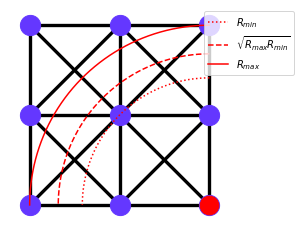

In [5]:
def find_UDG_radius(position, graph):
    '''
    Computes the optimal unit disk radius for a particular set of positions and graph.
    position   - [N x 2] array of points
    graph       - network connectivity graph. This should be a unit disk graph.
    
    returns
    radius      - Optimal unit disk radius of the graph
    rmin        - Minimum distance
    rmax        - Maximum distance
    '''
    
    dists = np.sqrt((position[:,0,None] - position[:,0])**2
               + (position[:,1,None] - position[:,1])**2)
    rmin = 0
    rmax = np.inf
    for i in range(position.shape[0]):
        for j in range(i+1,position.shape[0]):
            if (i,j) in graph.edges:
                if rmin<dists[i,j]:
                    rmin = dists[i,j]
            elif (i,j) not in graph.edges:
                if rmax>dists[i,j]:
                    rmax = dists[i,j]
    
    if rmin>rmax:
        print(rmin,rmax)
        raise BaseException("Graph is not a unit disk graph!")
    
    return np.sqrt(rmin*rmax),rmin,rmax

# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,small_G)




# Visualize using networkx
fig = plt.figure()
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)


# Draw the minimum and maximum unit disk radius of the graph
x0,y0 = (2,0)
angles = np.linspace(np.pi/2,np.pi,1001)
ax.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
ax.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
ax.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

ax.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
ax.set_xlim((-0.25,3))
plt.legend(loc="upper right",)
plt.show()

Blockade radius of Rydberg system is 8.044e-06m
Unit disk radius of logical graph is 1.682


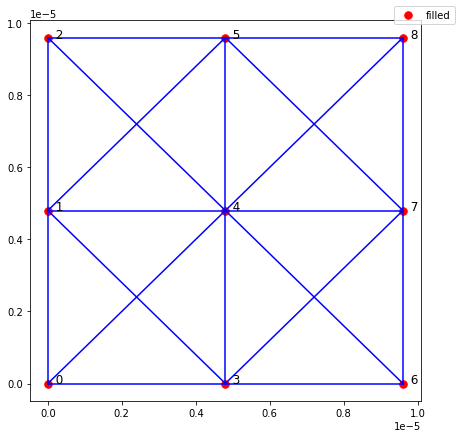

In [6]:
from iquhack_utils import get_blockade_radius,C6
Delta_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(Delta_final, 0) # no rabi amplitude at the end
print('Blockade radius of Rydberg system is {:0.3e}m'.format(blockade_radius))
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius

# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
small_register = AtomArrangement()
for x in pos:
    small_register.add((a * x).round(7))
    
    
from quera_ahs_utils.plotting import show_register
show_register(small_register,blockade_radius = a*1.5)


In [7]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

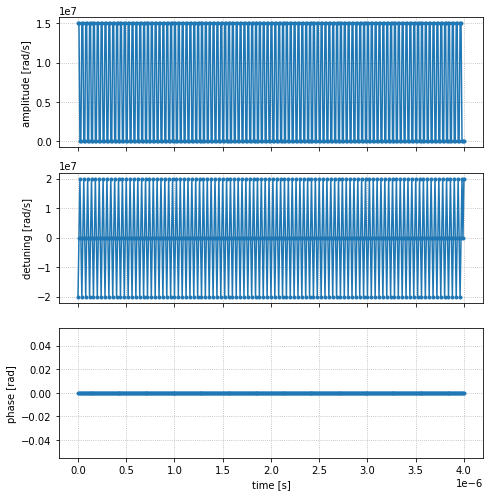

In [8]:
# Define a set of time points
n_flux = 100 # Number of alternations of problem and mixer hamiltonian for QAOA
max_time = float(capabilities.rydberg.dict()['rydbergGlobal']['timeMax'])
time_points = [i*max_time/(n_flux*4) for i in range(4*n_flux+1)]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 15e6  # rad / sec

# Define the strength of the detuning Δ
Delta_initial = -20e6     # rad / sec
Delta_final = Delta_final # Defined above

# Define the total drive
from quera_ahs_utils.plotting import show_global_drive
from quera_ahs_utils.drive import get_drive 

amplitude_pattern = n_flux*[1,1,0,0] + [0]
detuning_pattern = n_flux*[-1,0,1,0] + [1]
phase_pattern = n_flux*[0,0,0,0] + [0]

amplitude_values = [amplitude_max*elem for elem in amplitude_pattern]  # piecewise linear
detuning_values = [Delta_final*elem for elem in detuning_pattern]  # piecewise linear
phase_values = [2*np.pi*elem for elem in phase_pattern]  # piecewise constant


# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

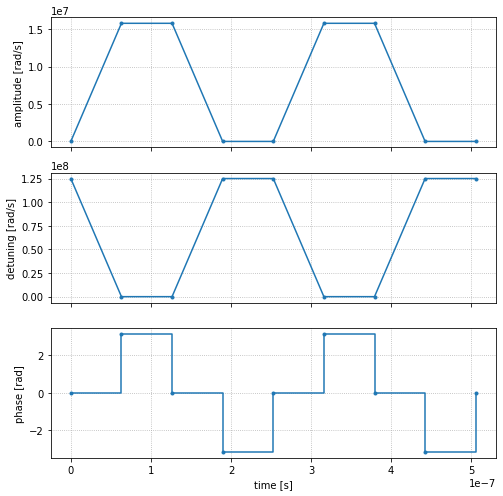

In [42]:
max_time = float(capabilities.rydberg.dict()['rydbergGlobal']['timeMax'])
time_res = float(capabilities.rydberg.dict()['rydbergGlobal']['timeResolution'])

max_rabi = float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencyRange'][1])
rabi_res = float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencyResolution'])

max_detuning = float(capabilities.rydberg.dict()['rydbergGlobal']['detuningRange'][1])
detuning_res = float(capabilities.rydberg.dict()['rydbergGlobal']['detuningResolution'])

max_slew_rate = min(
    float(capabilities.rydberg.dict()['rydbergGlobal']['detuningSlewRateMax']),
    float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencySlewRateMax'])
)
ramp_time = max_rabi/max_slew_rate # run = slope/rise. This is greater than time res

p = 3
time_without_ramps = max_time - 2*ramp_time*p
init_params = [(max_time - time_without_ramps)/6 for i in range(2*p)] # default params [mixer, cost]

def get_ham_values(params):
    max_rabi = 15800000.0
    max_detuning = 125000000.0
    
    p = int(len(params)/2)
    time_points = [0]
    amplitude_values = [0]
    detuning_values = [max_detuning]
    phase_values = [0]
    time_count = 0
    
    for i in range(0,p,2):
        time_points.extend([
            time_count+ramp_time, time_count+ramp_time + params[i], 
            time_count+ramp_time+params[i] + ramp_time, time_count+ramp_time+params[i] + ramp_time + params[i+1]
        ])

        time_count = time_points[-1]

        amplitude_values.extend([max_rabi, max_rabi, 0, 0])
        detuning_values.extend([0, 0, max_detuning, max_detuning])
        phase_values.extend([np.pi, 0, -1*np.pi, 0])
        
    return time_points, amplitude_values, detuning_values, phase_values
    
time_points, amplitude_values, detuning_values, phase_values = get_ham_values(init_params)
    
# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [34]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
small_ahs_program = AnalogHamiltonianSimulation(
    register=small_register, 
    hamiltonian=drive
)

In [35]:
device = LocalSimulator("braket_ahs")
small_ahs_run = device.run(small_ahs_program, shots=1000)


def save_result_json(json_file,result):
    '''
    Helper function to save results locally
    '''
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    with open(json_file,"w") as io:
        json.dump(result_dict,io,indent=2)
        
def open_json(json_file):
    '''
    Helper function to load and open json data
    '''
    with open(json_file,"r") as io:
        return json.load(io) 

    
# Results are loaded and saved to file
result  = small_ahs_run.result()
save_result_json("classical_results/small_kings_graph_mis_trial_1.json",result)


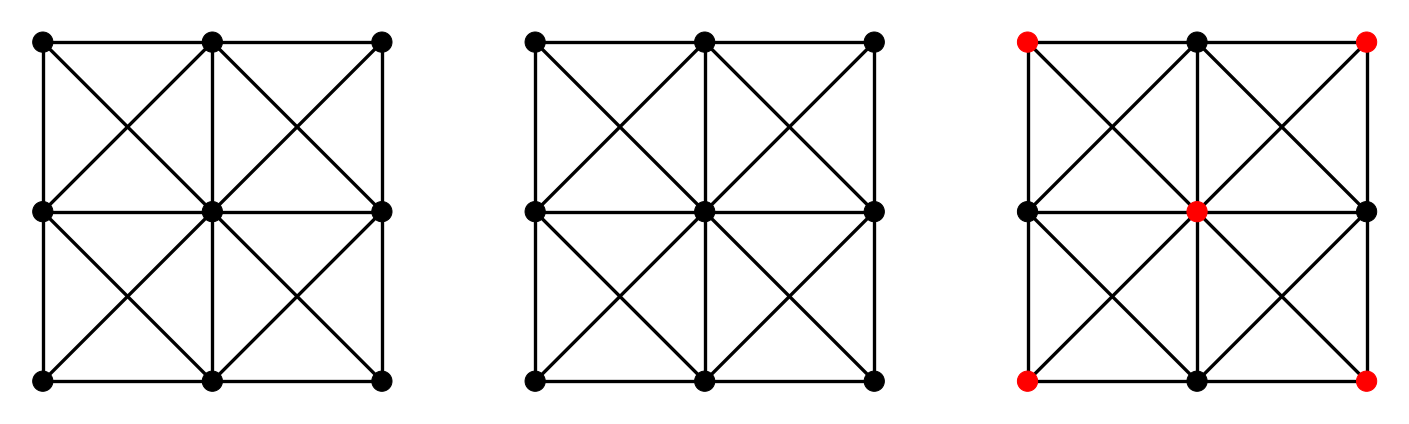

In [36]:
trial_file = "classical_results/small_kings_graph_mis_trial_1.json"
result_json = open_json(trial_file)
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()

In [37]:
def postprocess_MIS(G,results):
    '''
    Removes vertices that violate the independent set condition
    G - networkx graph
    results - an AWS AnalogHamiltonianSimulationQuantumTaskResult
    
    returns
    data_out - a list of bitstrings which are valid independent sets of G
    '''
    data_out = []
    for measurement in results["measurements"]: # For each measurement...
        pre_sequence = np.array(measurement["pre_sequence"])
        post_sequence = np.array(measurement["post_sequence"])
        if np.any(pre_sequence==0): continue # skip anyshots with defects
            
        bitstring = post_sequence
        inds = np.nonzero(bitstring==0)[0]    # Find indices of IS vertices
        if len(inds) == 0: continue
        subgraph = nx.subgraph(G,inds)        # Generate a subgraph from those vertices. If the bitstring is an independent set, this subgraph has no edges.
        inds2 = nx.maximal_independent_set(subgraph,seed=0) # Find the mIS of this subgraph. If there are no edges, it is the original bitstring. Else, it randomly chooses within each graph.
        payload = np.ones(len(bitstring))     # Forge into the correct data structure (a list of 1s and 0s)
        payload[inds2] = 0
        data_out.append(payload)
        
    if len(data_out) == 0: 
        raise ValueError("no independent sets found! increase number of shots.")
        
    return np.asarray(data_out)

def analysis_MIS(graph,result_json, print_extra = True):
    '''
    Helper function to analyze a MIS result and plot data
    '''

    post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
    pp_bitstrings = postprocess_MIS(graph, result_json)


    IS_sizes = np.sum(1-pp_bitstrings,axis=1)
    unique_IS_sizes,counts = np.unique(IS_sizes,return_counts=True)


    if print_extra:
        avg_no_pp = 'Average pre-processed size:  {:0.4f}'.format( (1-post_bitstrings).sum(axis=1).mean() )
        print(avg_no_pp)
    avg_pp = 'Average post-processed IS size: {:0.4f}'.format(IS_sizes.mean())
    print(avg_pp)
    
    if print_extra:
        plt.bar(unique_IS_sizes,counts/counts.sum())
        plt.xticks(unique_IS_sizes)
        plt.xlabel("IS sizes",fontsize=14)
        plt.ylabel("probability",fontsize=14)
        plt.show()
    
    return IS_sizes,pp_bitstrings
    



Average pre-processed size:  0.6980
Average post-processed IS size: 1.3864


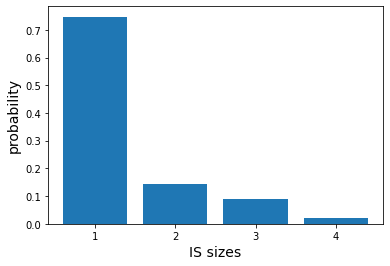

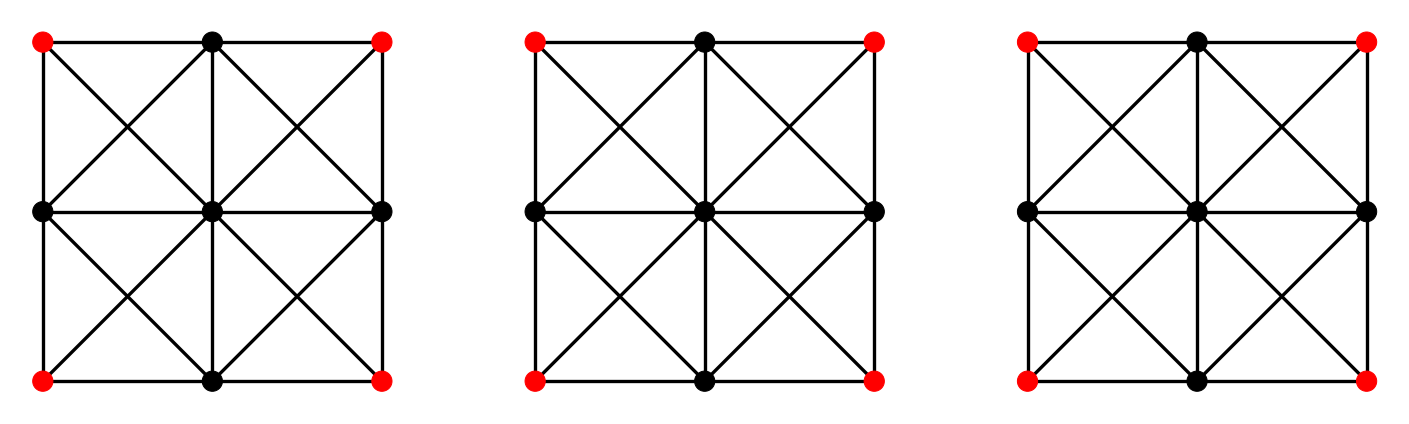

In [38]:
result_json = open_json(trial_file)
IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),3)

fig = plt.figure(figsize=(25,15))
for i in range(n_show):
    ax = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()
    


    

In [43]:
def objective(params):
    scaled_params = [elem*10**(-6) for elem in params]
    time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_params)
    # Define the drive
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
    #show_global_drive(drive);
    
    small_ahs_program = AnalogHamiltonianSimulation(
        register=small_register, 
        hamiltonian=drive
    )
    
    # Define Device
    device = LocalSimulator("braket_ahs")
    small_ahs_run = device.run(small_ahs_program, shots=1000)
    
    # Run
    result  = small_ahs_run.result()
    
    # Store results in json string
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    #json.dumps(result_dict,io,indent=2) # dumps instead of dump to avoid saving file
    
    IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_dict, print_extra=False)
    return -1*IS_sizes.mean() # Multiply by -1 since we want to minimze rather than maximize

def enforce_time_bound(x):
    return 0.000004*(10**6) - (sum(x) + (15800000.0*(10**6)/250000000000000.0)*(len(x)))

def enforce_positive_params(x):
    for elem in x:
        if elem < 0:
            return -1 # penalty for negative parameter
    
    return 1

cons = (
    {
        'type': 'ineq', 
        'fun': enforce_time_bound # sum of times must be less than max time
    },
    {
        'type': 'ineq',
        'fun': enforce_positive_params
    }
)

init_params = [elem*10**6 for elem in init_params]
optimized_params = minimize(objective, init_params, method='COBYLA', constraints = cons)

Average post-processed IS size: 1.4164
Average post-processed IS size: 2.0728
Average post-processed IS size: 1.7487
Average post-processed IS size: 2.1246
Average post-processed IS size: 1.9753
Average post-processed IS size: 2.0967
Average post-processed IS size: 2.1754
Average post-processed IS size: 2.2409
Average post-processed IS size: 1.9744
Average post-processed IS size: 2.0400
Average post-processed IS size: 1.9638
Average post-processed IS size: 1.9245
Average post-processed IS size: 1.8450
Average post-processed IS size: 2.0691
Average post-processed IS size: 1.8436
Average post-processed IS size: 2.4108
Average post-processed IS size: 1.9869
Average post-processed IS size: 2.2561
Average post-processed IS size: 1.9410
Average post-processed IS size: 2.3554
Average post-processed IS size: 2.3822
Average post-processed IS size: 2.2696
Average post-processed IS size: 2.3595
Average post-processed IS size: 2.6501
Average post-processed IS size: 2.1633
Average post-processed IS

In [47]:
print(optimized_params)

     fun: -2.668831168831169
   maxcv: 1.0
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 66
  status: 4
 success: False
       x: array([ 1.95530549, -0.37557566,  1.16592846, -0.10135442,  0.06870458,
        1.21442959])
1.0


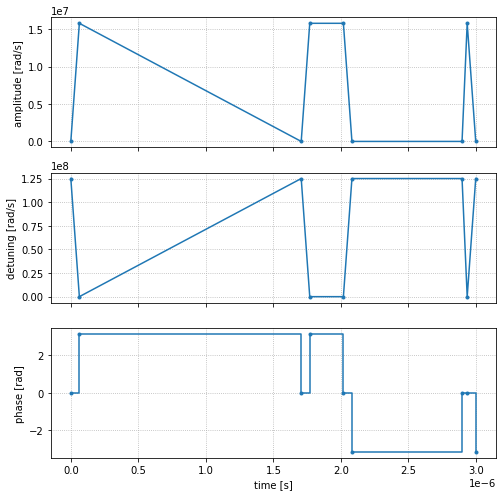

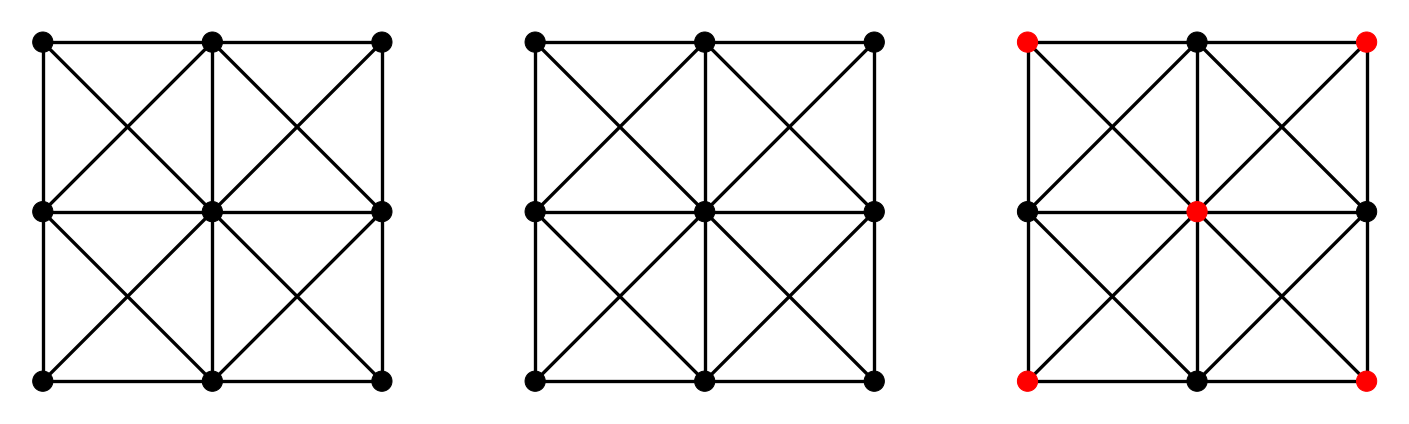

In [45]:
scaled_optimal_params = [elem*(10**-6) for elem in optimized_params['x']]
time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_optimal_params)

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

small_ahs_program = AnalogHamiltonianSimulation(
    register=small_register, 
    hamiltonian=drive
)

device = LocalSimulator("braket_ahs")
small_ahs_run = device.run(small_ahs_program, shots=1000)

trial_file = "classical_results/small_kings_graph_mis_trial_1.json"
result_json = open_json(trial_file)
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))

for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()